In [1]:
import numpy as np
import requests
import torch
import torch.nn as nn
from torch.nn import functional as F
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparams
batch_size = 64 # num of independent sequences
context_size = 256 # max context window for pred
max_iters = 5000
eval_interval = 200
eval_iters = 200
n_emb = 512
learning_rate = 1e-3
n_heads = 8
n_layers = 8 # number of block layers
dropout = 0.4

In [3]:
files_list = [
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/tlp.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/alice.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/oz.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/peter and wendy.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/pooh.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/eighty.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/pride and prejudice.txt",
    "https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/twenty.txt"
    ]

text = ""

for file in files_list:
    try:
        !wget -O temp_file.txt {file}
        with open("temp_file.txt", 'r', encoding='utf-8') as f:
            text += f.read()
    except Exception as e:
        print(f'Error fetching text from {file}: {e}')
    finally:
        !rm -f temp_file.txt

--2024-07-07 20:01:59--  https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/tlp.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91824 (90K) [text/plain]
Saving to: 'temp_file.txt'

temp_file.txt       100%[===================>]  89.67K  --.-KB/s    in 0.02s   

2024-07-07 20:01:59 (5.00 MB/s) - 'temp_file.txt' saved [91824/91824]

--2024-07-07 20:02:01--  https://raw.githubusercontent.com/yaszkm/FictionGPT/main/data/alice.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151219 (148K) [text/plain]
Saving to: 'temp

In [4]:
print(f"Dataset length in chars: {len(text)}")

Dataset length in chars: 2277985


In [5]:
print(text[:600])

Once when I was six years old I saw a magnificent picture in a book, called True Stories from Nature, about the primeval forest. It was a picture of a boa constrictor in the act of swallowing an animal. Here is a copy of the drawing.

In the book it said: "Boa constrictors swallow their prey whole, without chewing it. After that they are not able to move, and they sleep through the six months that they need for digestion." I pondered deeply, then, over the adventures of the jungle. And after some work with a colored pencil I succeeded in making my first drawing.

My Drawing Number One. It look


In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"ORIGINAL TEXT\nChars:{''.join(chars)}\nVocab size: {vocab_size}")
cleaned_text = re.sub(r"[ \t　]+", ' ', text) # replace any tab and full-width spaces with a space
chars = sorted(list(set(cleaned_text)))
vocab_size = len(chars)
print(f"\nCLEANED TEXT\nChars:{''.join(chars)}\nVocab size: {vocab_size}")

ORIGINAL TEXT
Chars:	
 !"$&'()*,-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz£½âæèéïôùœ—‘’“”　
Vocab size: 97

CLEANED TEXT
Chars:
 !"$&'()*,-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz£½âæèéïôùœ—‘’“”
Vocab size: 95


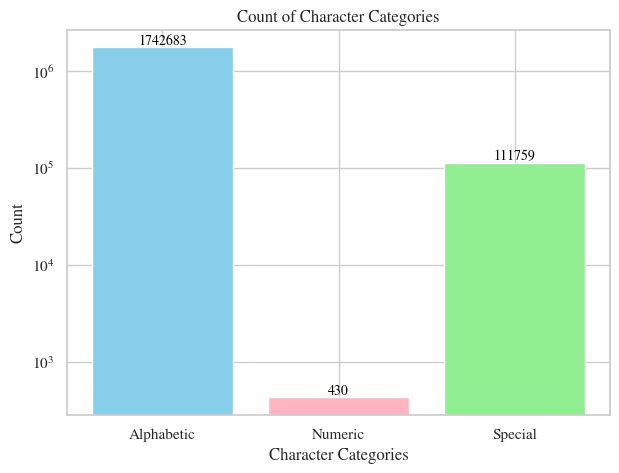

In [7]:
alpha_pattern = r'[A-Za-z]'
numeric_pattern = r'\d'
special_pattern = r'[^\w\s]' # any character that is not alphanumeric or whitespace

def count_characters(text, pattern):
    # count characters based on regex pattern
    return len(re.findall(pattern, cleaned_text))

# frequency counts
alpha_count = count_characters(cleaned_text, alpha_pattern)
numeric_count = count_characters(cleaned_text, numeric_pattern)
special_count = count_characters(cleaned_text, special_pattern)

categories = ["Alphabetic", "Numeric", "Special"]
counts = [alpha_count, numeric_count, special_count]

sns.set(style="whitegrid", font="STIXGeneral")
plt.figure(figsize=(7, 5))
bars = plt.bar(categories, counts, color=["skyblue", "lightpink", "lightgreen"])
plt.yscale("log") # log scale for y-axis
plt.xlabel("Character Categories")
plt.ylabel("Count")
plt.title("Count of Character Categories")

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
             ha="center", va="bottom", fontsize=10, color="black") # display counts above bars

plt.show()

In [8]:
def plot_category_frequencies(text, pattern, category_name, width, height, color):
    chars = sorted(set(re.findall(pattern, cleaned_text))) # find unique characters matching the pattern
    char_counts = [text.count(char) for char in chars] # character frequencies counts

    plt.figure(figsize=(width, height))
    bars = plt.bar(chars, char_counts, color=color)
    plt.xlabel("Characters")
    plt.ylabel("Frequency")
    plt.title(f"Frequency of {category_name} Characters")
    plt.xlim(-0.5, len(chars)-0.5)  # Adjust x-axis limits dynamically

    for bar, count in zip(bars, char_counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha="center", va="bottom", fontsize=8, color="black")

    if category_name != "Numeric":
      plt.yscale("log")

    plt.show()

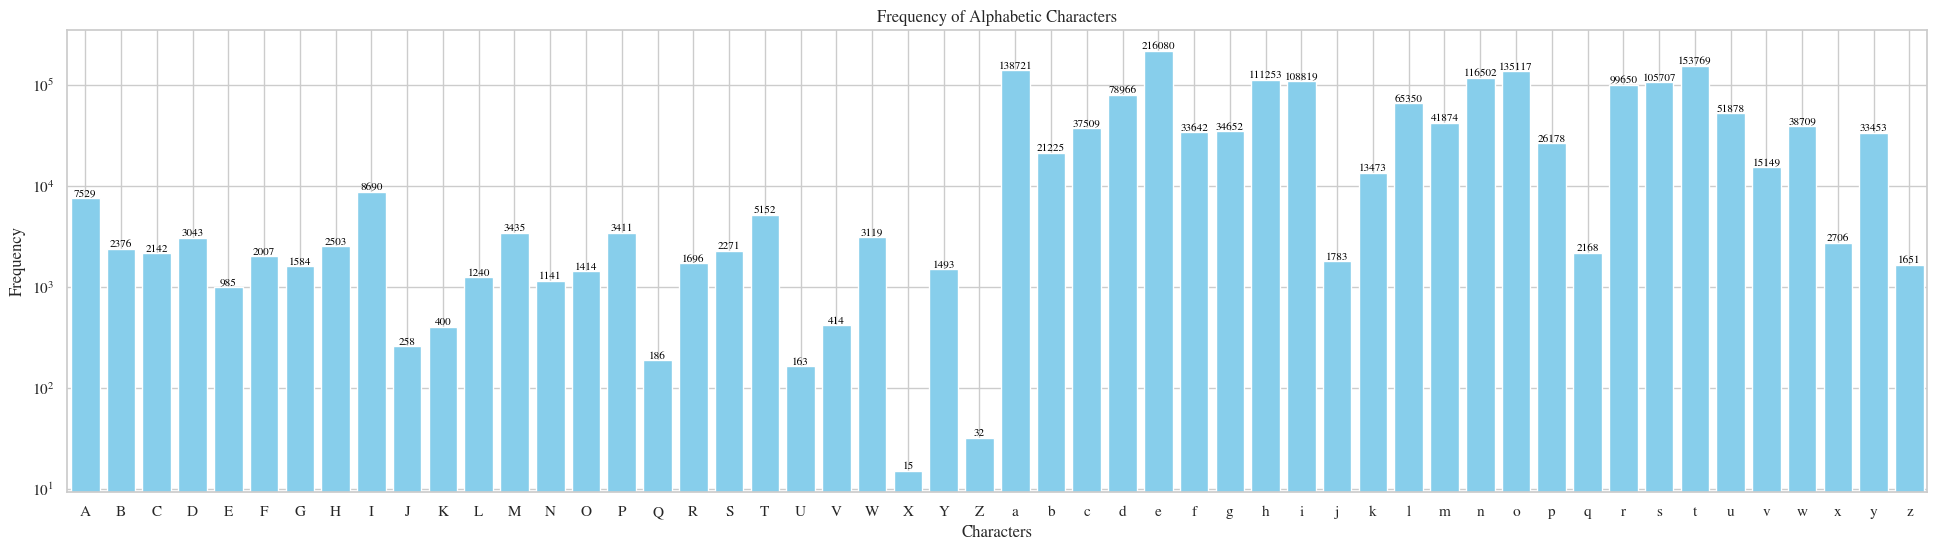

In [9]:
plot_category_frequencies(cleaned_text, alpha_pattern, 'Alphabetic', 24, 6, 'skyblue')

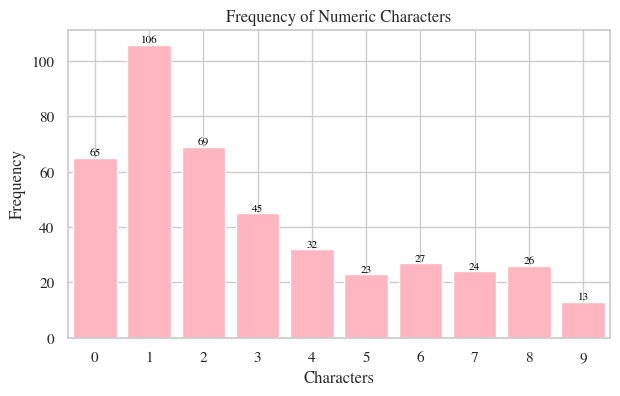

In [10]:
plot_category_frequencies(cleaned_text, numeric_pattern, 'Numeric', 7, 4, 'lightpink')

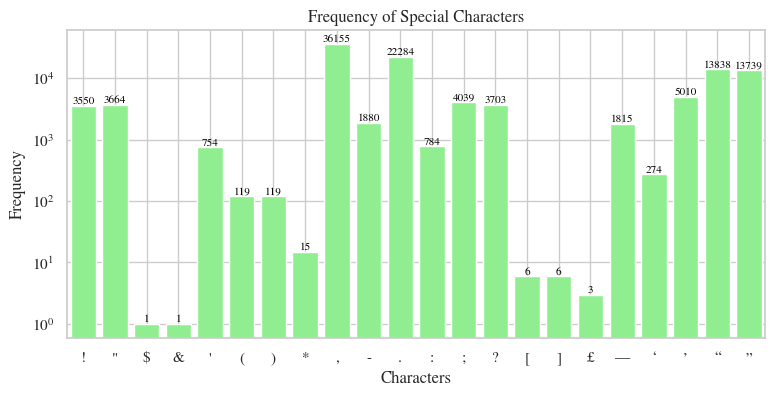

In [11]:
plot_category_frequencies(cleaned_text, special_pattern, 'Special', 9, 4, 'lightgreen')

In [12]:
# map characters to integers
ctoi = { ch:i for i, ch in enumerate(chars) } # dic where each character is mapped to an index
itoc = { i:ch for i, ch in enumerate(chars) } # dic where each index is mapped to a character
encode = lambda s: [ctoi[c] for c in s] # string -> list of ints
decode = lambda l: ''.join([itoc[i] for i in l]) # list of ints -> string

print(encode("hello, gpt!"))
print(decode((encode("hello, gpt!"))))

[61, 58, 65, 65, 68, 10, 1, 60, 69, 73, 2]
hello, gpt!


In [13]:
# encode the entire dataset
data = torch.tensor(encode(cleaned_text), dtype=torch.long)

print(data.shape, data.dtype)
print(data[:600])

torch.Size([2277457]) torch.int64
tensor([40, 67, 56, 58,  1, 76, 61, 58, 67,  1, 34,  1, 76, 54, 72,  1, 72, 62,
        77,  1, 78, 58, 54, 71, 72,  1, 68, 65, 57,  1, 34,  1, 72, 54, 76,  1,
        54,  1, 66, 54, 60, 67, 62, 59, 62, 56, 58, 67, 73,  1, 69, 62, 56, 73,
        74, 71, 58,  1, 62, 67,  1, 54,  1, 55, 68, 68, 64, 10,  1, 56, 54, 65,
        65, 58, 57,  1, 45, 71, 74, 58,  1, 44, 73, 68, 71, 62, 58, 72,  1, 59,
        71, 68, 66,  1, 39, 54, 73, 74, 71, 58, 10,  1, 54, 55, 68, 74, 73,  1,
        73, 61, 58,  1, 69, 71, 62, 66, 58, 75, 54, 65,  1, 59, 68, 71, 58, 72,
        73, 12,  1, 34, 73,  1, 76, 54, 72,  1, 54,  1, 69, 62, 56, 73, 74, 71,
        58,  1, 68, 59,  1, 54,  1, 55, 68, 54,  1, 56, 68, 67, 72, 73, 71, 62,
        56, 73, 68, 71,  1, 62, 67,  1, 73, 61, 58,  1, 54, 56, 73,  1, 68, 59,
         1, 72, 76, 54, 65, 65, 68, 76, 62, 67, 60,  1, 54, 67,  1, 54, 67, 62,
        66, 54, 65, 12,  1, 33, 58, 71, 58,  1, 62, 72,  1, 54,  1, 56, 68, 69,
      

In [14]:
# split the data into train (90%) and validation sets
n = int(len(data)*0.9)
train_set = data[:n]
val_set = data[n:]

In [15]:
torch.manual_seed(1337)

# load data
def get_batch(split):
  data = train_set if split == "train" else val_set
  ix = torch.randint(len(data) - context_size, (batch_size,)) # batch_size number of random offsets
  x = torch.stack([data[i:i+context_size] for i in ix])
  y = torch.stack([data[i+1:i+context_size+1] for i in ix])
  x, y = x.to(device), y.to(device)
  return x, y

xb, yb = get_batch("train")

In [16]:
print(f"Input: {xb.shape}") # transformer input
print(xb)

print(f"\nTargets: {yb.shape}\n")

for b in range(batch_size)[:1]: # batch dim
  for t in range(context_size)[:10]: # time dim
    context = xb[b, :t+1]
    target = yb[b, t]
    print(f"When the input is {context.tolist()}, the target is {target}")

Input: torch.Size([64, 256])
tensor([[58, 71, 58,  ...,  1, 54, 72],
        [ 1, 76, 58,  ..., 58,  1, 73],
        [73, 61, 58,  ..., 68, 75, 58],
        ...,
        [62, 67, 62,  ..., 74, 69, 68],
        [58, 54, 66,  ..., 58, 54, 56],
        [76, 61, 68,  ..., 74, 72, 54]], device='cuda:0')

Targets: torch.Size([64, 256])

When the input is [58], the target is 71
When the input is [58, 71], the target is 58
When the input is [58, 71, 58], the target is 1
When the input is [58, 71, 58, 1], the target is 56
When the input is [58, 71, 58, 1, 56], the target is 54
When the input is [58, 71, 58, 1, 56, 54], the target is 66
When the input is [58, 71, 58, 1, 56, 54, 66], the target is 58
When the input is [58, 71, 58, 1, 56, 54, 66, 58], the target is 1
When the input is [58, 71, 58, 1, 56, 54, 66, 58, 1], the target is 54
When the input is [58, 71, 58, 1, 56, 54, 66, 58, 1, 54], the target is 1


In [17]:
torch.manual_seed(1337)

@torch.no_grad()
def estimate_loss():
  out = {}
  model.eval()
  for split in ["train", "val"]:
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [18]:
class Head(nn.Module):
  # single head self-attention

  def __init__(self, head_size):
    super().__init__()
    self.query = nn.Linear(n_emb, head_size, bias=False)
    self.key = nn.Linear(n_emb, head_size, bias=False)
    self.value = nn.Linear(n_emb, head_size, bias=False)
    self.register_buffer("tril", torch.tril(torch.ones(context_size, context_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    q = self.query(x) # (B, T, head_size)
    k = self.key(x) # (B, T, head_size)

    # compute affinities (attention scores)
    weights = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5 # (B, T, head_size) @ (B, head_size, T) = (B, T, T)
    weights = weights.masked_fill(self.tril[:T, :T] == 0, float("-inf")) # masking. (B, T, T)
    weights = F.softmax(weights, dim=-1) # normalizing. (B, T, T)
    weights = self.dropout(weights)

    # weighted aggregations of past elements
    v = self.value(x) # (B, T, head_size)
    out = weights @ v # (B, T, T) @ (B, T, head_size) = (B, T, head_size)

    return out

In [19]:
class MultiHeadAttention(nn.Module):
  # parallel multi self-attention heads

  def __init__(self, n_heads, head_size):
    super().__init__()
    self.heads = nn.ModuleList([Head(head_size) for _ in range(n_heads)])
    self.proj = nn.Linear(n_emb, n_emb)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out)) # linear transformation of the outcome of the cat layer with dropout
    return out

In [20]:
class FeedForward(nn.Module):
  # mlp. a simple linear layer followed by non-lonearity

  def __init__(self, head_size):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(n_emb, 4 * n_emb),
        nn.ReLU(),
        nn.Linear(4 * n_emb, n_emb), # projection layer
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

In [21]:
class Block(nn.Module):
  # transformer block

  def __init__(self, n_emb, n_heads):
    # n_emb: embedding dim
    # n_heads: the number of heads
    super().__init__()
    head_size = n_emb // n_heads
    self.sa = MultiHeadAttention(n_heads, head_size) # communication
    self.ff = FeedForward(n_emb) # computation
    self.ln1 = nn.LayerNorm(n_emb)
    self.ln2 = nn.LayerNorm(n_emb)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ff(self.ln2(x))
    return x

In [22]:
class GPT_LM(nn.Module):

  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_emb)
    self.position_embedding_table = nn.Embedding(context_size, n_emb)
    self.blocks = nn.Sequential(*[Block(n_emb, n_heads=n_heads) for _ in range(n_layers)])
    self.ln_f = nn.LayerNorm(n_emb) # final layer norm
    self.lm_head = nn.Linear(n_emb, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    tok_emb = self.token_embedding_table(idx) # (batch, time, channel) tensor; time = context, channel = n_emb
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (time, channel)
    x = tok_emb + pos_emb # encode the info with the token and pos embeddings. (batch, time, channel)
    x = self.blocks(x) # (B, T, C)
    x = self.ln_f(x) # (B, T, C)
    logits = self.lm_head(x) # (batch, time, vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(-1) # reshape to B*T, as it needs to be 1-dim
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -context_size:] # crop idx to last context_size tokens to prevent out-of-scope position embeddings
      logits, _ = self(idx_cond) # get preds
      logits = logits[:, -1, :] # the last time step. becomes (B, C) instead of (B, T, C)
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1) # sample from dis. (B, 1)
      idx = torch.cat((idx, idx_next), dim=1) # append sampled index to the running sequence, creating (B, T+1)
    return idx

In [23]:
torch.manual_seed(1337)

model = GPT_LM()
m = model.to(device)

n_parameters = sum(p.numel() for p in m.parameters()) / 1e6
print(f"{n_parameters:.3f} million parameters\n")

logits, loss = m(xb, yb)
print(logits.shape)
print(f"\nLoss: {loss}\nExpected loss: {-np.log(1/vocab_size)}")

25.436 million parameters

torch.Size([16384, 95])

Loss: 4.740961074829102
Expected loss: 4.553876891600541


In [24]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=600)[0].tolist()))


g*ôN]æAiha;?Q4?c?‘N0—UpQNX?AUoMô3xi2r9Sj7Ja(jâ]GtN'[7d*]L*4][gè'sf-a“2xïOBW
AjRZèkIp2ï&j?;b½15ô2ag-,cZiR8I2mRjLx’2!âéY
p’S3‘,ïYB'bè?!pS*5T40HdMéX?d]æ*pf7væôùùJAxô£RA!”*')Adïp(;è—&*&uN')NR7ætæ9w0!)a£2U:’9T.éB6,UXSô;½6&(WK6,eé“L1½!-'Hr26iPcùz918ZFAvS[ù03Mô4)HwïCcuN?APO5éJw:zu’L(8KTteq[qUk9b”l;wt—8D)8HxTNp1;2œ5KFY]”QKxuUX[ù½bcr)K)i8-dA),‘œâLxD?ln)½qæ”b]6œï 5tKR7B-e ’FâpAq'T9’XSrAiOgJFHô œ*cN?R
;9“)—aJiWIVAos,h)Jp"KAâ5f
U”?
g[H1ræ3z(Y R :Nsè[g’jssm-2TOuXWi&fjXY6(rZgA1RèOkua‘v ]â2e.Y!wœq-W-i
Tx(pO&wU’èMôgO[—s3ùâY'Lqph7dâHeï££$M,p’“u7oA’8,0,‘u;qH1
cu!æTfi ’HX[H6Bi&cùP½èl56:F[FIéùzq‘I4dôAA’GtLtxIwsue


In [25]:
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

In [26]:
train_losses = []
val_losses = []
all_train_losses = []

In [27]:
torch.manual_seed(1337)

for iter in range(max_iters):
  if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    train_loss_eval = losses['train']
    val_loss_eval = losses['val']
    train_losses.append(train_loss_eval)
    val_losses.append(val_loss_eval)
    # print(f"Step {iter}: train loss is {losses['train']:.4f}, val loss is {losses['val']:.4f}")
    print(f"Step {iter}: train loss is {train_loss_eval:.4f}, val loss is {val_loss_eval:.4f}")

  # sample a batch of data
  xb, yb = get_batch("train")

  # eval the loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

  train_loss = loss.item()
  all_train_losses.append(train_loss)

Step 0: train loss is 4.7495, val loss is 4.7482
Step 200: train loss is 2.4156, val loss is 2.3977
Step 400: train loss is 2.0143, val loss is 1.9983
Step 600: train loss is 1.7695, val loss is 1.7457
Step 800: train loss is 1.5676, val loss is 1.5432
Step 1000: train loss is 1.4354, val loss is 1.4179
Step 1200: train loss is 1.3497, val loss is 1.3422
Step 1400: train loss is 1.2728, val loss is 1.2723
Step 1600: train loss is 1.2296, val loss is 1.2338
Step 1800: train loss is 1.1904, val loss is 1.2067
Step 2000: train loss is 1.1526, val loss is 1.1771
Step 2200: train loss is 1.1260, val loss is 1.1572
Step 2400: train loss is 1.1051, val loss is 1.1475
Step 2600: train loss is 1.0833, val loss is 1.1340
Step 2800: train loss is 1.0632, val loss is 1.1178
Step 3000: train loss is 1.0453, val loss is 1.1105
Step 3200: train loss is 1.0301, val loss is 1.1012
Step 3400: train loss is 1.0172, val loss is 1.0989
Step 3600: train loss is 1.0012, val loss is 1.0917
Step 3800: train lo

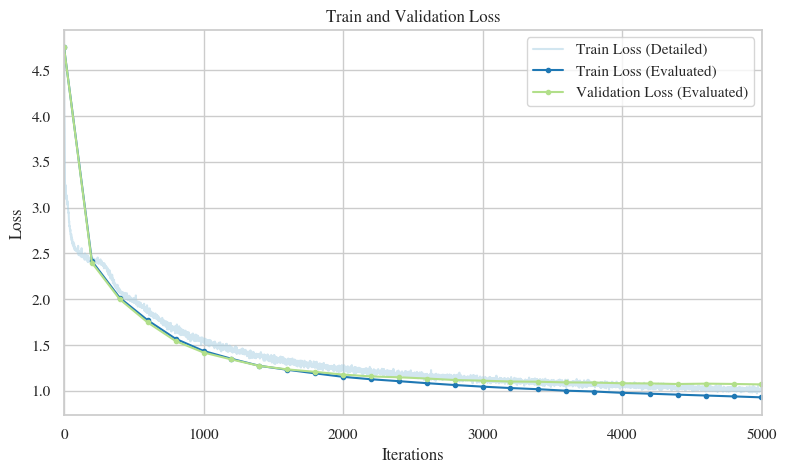

In [28]:
evaluation_steps = list(range(0, max_iters, eval_interval)) + [max_iters - 1]

sns.set(style="whitegrid", palette="Paired", font="STIXGeneral")
plt.figure(figsize=(9, 5))
plt.plot(range(max_iters), all_train_losses, label='Train Loss (Detailed)', alpha=0.5)
plt.plot(evaluation_steps, train_losses, '.-', label='Train Loss (Evaluated)')
plt.plot(evaluation_steps, val_losses, '.-', label='Validation Loss (Evaluated)')
plt.title('Train and Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.xlim(0, max_iters)
plt.show()

In [29]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=300)[0].tolist()))



“I think I love you, that must engitary to do you for rest.”

“Indeed!” cried the terminute sum.

Pistached, drawing firstly to the prince’s self, joying every personal hands until the pensionary, a cool of foon, and fapted on the world. Just then turned the carses of their arms dropps in andistrus


In [30]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=600)[0].tolist()))



“As one, my dear friend,
 This friends also. And you will be difficult, the duty would turn with ithere yours.”

“Sire, he!” said D’Artagnan.

The two men druring him out towart had each other steps, as unknown a velvet man inhabited is to burn in France, for he bowed.

“What shall I see him?” he added, turning down an expression.

“Princes!” answered Athos.

“It is made a Monsieur de Chevreuse?” asked De Winter.

“Well, I must go, we thought in the curse of the way,” said D’Artagnan.

“Ah, you must remember,” persisted he.

“Without monsieur,” said Athos, “where we do nothing with prisoners 


In [31]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
open('FictionGPT.txt', 'w').write(decode(m.generate(context, max_new_tokens=8000)[0].tolist()))

8001